# GitOps Flow with MLRun

In [3]:
# !pip install s3fs

## Setup Project

In [3]:
import os
import json
import mlrun
import pandas as pd

from config import AppConfig

config = AppConfig()

project = mlrun.get_or_create_project(
    name=config.project_name,
    parameters={
        "source" : config.archive_source,
        "secrets_file" : config.secrets_file,
        "artifact_path" : config.artifact_path,
        "force_build" : False
    }
)

> 2024-09-27 20:05:56,537 [warning] Overwriting artifact old db_key 'model' with new key 'model' - artifact can be fetched using the new key only
Project Source: v3io:///bigdata/cicd-flow.zip
Exporting project as zip archive to v3io:///bigdata/cicd-flow.zip...
> 2024-09-27 20:05:58,001 [info] Project loaded successfully: {'project_name': 'cicd-flow'}


## Log Training Set

In [13]:
dataset = project.log_dataset(key="heart", df=pd.read_csv(config.source_url))
dataset.uri

'store://datasets/cicd-flow/heart#0@50d363956eb5d8533016b7ac5efc364677d8a311'

## Run Training Pipeline

In [14]:
train_config = config.get_workflow_config(
    workflow_name="train",
    source_url=dataset.uri
)
train_config

{'source_url': 'store://datasets/cicd-flow/heart#0@50d363956eb5d8533016b7ac5efc364677d8a311',
 'label_column': 'target',
 'allow_validation_failure': True,
 'ohe_columns': ['sex', 'cp', 'slope', 'thal', 'restecg'],
 'test_size': 0.2}

In [15]:
project.notifiers.add_notification(notification_type="slack", params={"webhook": os.getenv("SLACK_WEBHOOK_URL")})

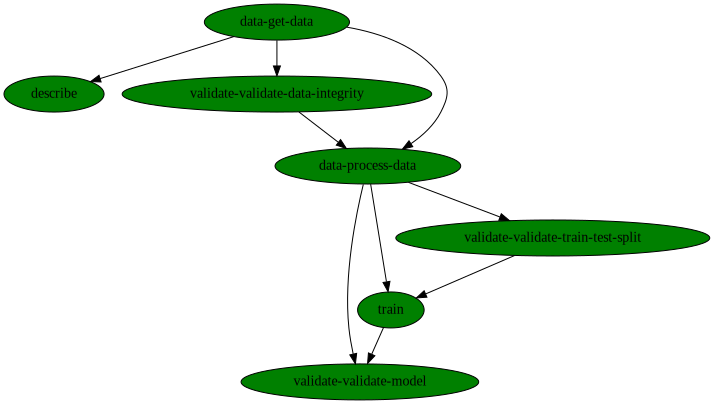

uid,start,state,name,parameters,results
...b8d94ded,Sep 27 20:01:50,completed,validate-validate-model,model_path=store://artifacts/cicd-flow/model@946d0f96-6532-4e2e-9d70-6df9f3e906ddlabel_column=targetallow_validation_failure=True,passed_suite=False
...687c61e0,Sep 27 20:01:06,completed,train,label_column=target,best_iteration=1accuracy=0.8596491228070176f1_score=0.8571428571428571precision_score=0.8275862068965517recall_score=0.8888888888888888
...630960a9,Sep 27 20:00:36,completed,validate-validate-train-test-split,label_column=targetallow_validation_failure=True,passed_suite=False
...dba73ebc,Sep 27 20:00:10,completed,data-process-data,"label_column=targettest_size=0.2ohe_columns=['sex', 'cp', 'slope', 'thal', 'restecg']",
...9054044b,Sep 27 19:59:40,completed,describe,label_column=target,
...26d0219d,Sep 27 19:59:40,completed,validate-validate-data-integrity,label_column=targetallow_validation_failure=True,passed_suite=True
...f0e96114,Sep 27 19:59:13,completed,data-get-data,,


In [16]:
run_id = project.run(
    name="train",
    arguments=train_config,
    dirty=True,
    watch=True
)

## Run Deployment Pipeline

In [7]:
deploy_config = config.get_workflow_config(workflow_name="deploy")

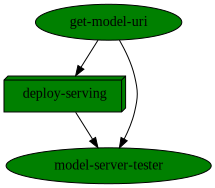

uid,start,state,name,parameters,results
...07ae2d8d,Sep 27 19:45:41,completed,model-server-tester,addr=http://cicd-flow-serving.default-tenant.app.cst-360.iguazio-cd0.com/label_column=targetmodel=model,total_tests=20errors=0match=8avg_latency=50987min_latency=47980max_latency=56178
...1d97f4f8,Sep 27 19:40:41,completed,get-model-uri,model_name=modelmodel_tag=challenger,model_uri=store://models/cicd-flow/model#0:challengertest_set_uri=s3://iguazio-demo/projects/cicd-flow/artifacts/f64aebfc-345a-498e-8dd8-73932c06ddba/train/1/test_set.parquet


In [8]:
run_id = project.run(
    name="deploy",
    arguments=deploy_config,
    dirty=True,
    watch=True
)

### Invoke Model

In [9]:
# Get serving function
serving_fn = project.get_function("serving")
model_name = config.deploy_model_name
label_column = config.label_column

# Get test set
df = project.get_artifact("data-process-data_test").to_dataitem().as_df()
display(df.head())

# Transform to list
# Get training set as list
data = df.drop(label_column, axis=1).to_dict(orient="split")["data"]

,sex_female,sex_male,cp_asymtomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,slope_downsloping,slope_flat,slope_upsloping,thal_fixed_defect,...,restecg_st-t_wave_abnormality,age,exang,fbs,trestbps,chol,thalach,oldpeak,ca,target
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,54.0,1.0,0.0,122.0,286.0,116.0,3.2,2.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,58.0,1.0,0.0,128.0,216.0,131.0,2.2,3.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,54.0,0.0,0.0,150.0,232.0,165.0,1.6,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,60.0,1.0,0.0,130.0,206.0,132.0,2.4,2.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,62.0,0.0,0.0,124.0,209.0,163.0,0.0,0.0,1.0


In [10]:
serving_fn.invoke(
    f"v2/models/{model_name}/infer", json.dumps({"inputs": data[:5]})
)

> 2024-09-27 19:46:44,641 [info] Invoking function: {'method': 'POST', 'path': 'http://nuclio-cicd-flow-serving.default-tenant.svc.cluster.local:8080/v2/models/model/infer'}


{'id': 'd1fcef26-de8a-42ab-b6ba-a3e0aeba096c',
 'model_name': 'model',
 'outputs': [0.0, 0.0, 1.0, 0.0, 1.0]}

### Simulate Traffic

MLRun real-time drift detection requires 10,000 events

In [11]:
import json
import logging
from random import choice

from tqdm.notebook import tqdm

# Suppress print messages
logging.getLogger(name="mlrun").setLevel(logging.WARNING)

# Simulate traffic using random elements from training set
for i in tqdm(range(10)):
    data_point = choice(data)
    resp = serving_fn.invoke(
        f"v2/models/{model_name}/infer", json.dumps({"inputs": [data_point]})
    )
    print(resp)

# Resume normal logging
logging.getLogger(name="mlrun").setLevel(logging.INFO)

  0%|          | 0/10 [00:00<?, ?it/s]

{'id': 'eb2e66bf-0431-472a-806b-b0de78a44fa3', 'model_name': 'model', 'outputs': [1.0]}
{'id': 'f052c538-2f75-451f-9568-b1cf6e5eb50c', 'model_name': 'model', 'outputs': [1.0]}
{'id': '612a81a3-3a1b-4aab-8b7d-dcbcc1fc4a9c', 'model_name': 'model', 'outputs': [1.0]}
{'id': '968340e9-b11a-43c9-ae36-d9bbe0ffe5af', 'model_name': 'model', 'outputs': [0.0]}
{'id': 'ca0a73d0-b65c-47e0-8a3c-a82beeb98c9c', 'model_name': 'model', 'outputs': [0.0]}
{'id': '1c407ae2-281d-46a3-a149-7051cff6fd26', 'model_name': 'model', 'outputs': [0.0]}
{'id': 'c6e66603-c736-4961-836c-c800be220910', 'model_name': 'model', 'outputs': [1.0]}
{'id': '06213c05-1b85-41f7-8717-e2a1bde5563e', 'model_name': 'model', 'outputs': [0.0]}
{'id': '0d4b9d78-7130-47be-95a4-799ee2b52c4d', 'model_name': 'model', 'outputs': [1.0]}
{'id': '867bdb4b-46f6-4eca-96f2-805c04ac3d88', 'model_name': 'model', 'outputs': [1.0]}
